## Data pipeline with Keras and tf.data

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential, Model
%matplotlib inline



![CIFAR-100 overview image](data/cifar100.png)

#### The CIFAR-100 Dataset

In the second part of this assignment, you will use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This image dataset has 100 classes with 500 training images and 100 test images per class. 

* A. Krizhevsky. "Learning Multiple Layers of Features from Tiny Images". April 2009 

Your goal is to use the tf.data module preprocessing tools to construct a data ingestion pipeline including filtering and function mapping over the dataset to train a neural network to classify the images.

#### Load the dataset

In [25]:
# Load the data, along with the labels

(train_data, train_labels), (test_data, test_labels) = cifar100.load_data(label_mode='fine')
with open('data/cifar100/cifar100_labels.json', 'r') as j:
    cifar_labels = json.load(j)

#### Display sample images and labels from the training set

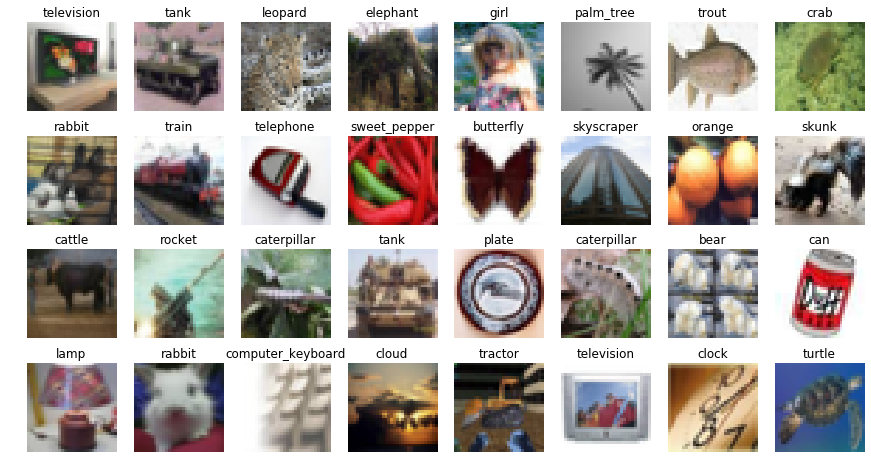

In [26]:
# Display a few images and labels

plt.figure(figsize=(15,8))
inx = np.random.choice(train_data.shape[0], 32, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(4, 8, n+1)
    plt.imshow(train_data[i])
    plt.title(cifar_labels[int(train_labels[i])])
    plt.axis('off')

#### Create Dataset objects for the train and test images

We should now write a function to create a `tf.data.Dataset` object for each of the training and test images and labels. This function should take a numpy array of images in the first argument and a numpy array of labels in the second argument, and create a `Dataset` object. 

Your function should then return the `Dataset` object.

In [27]:
def create_dataset(data, labels):

    """
    This function takes a numpy array batch of images in the first argument, and
    a corresponding array containing the labels in the second argument.
    The function should then create a tf.data.Dataset object with these inputs
    and outputs, and return it.
    """
    
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return dataset  

In [28]:
# Convert the training and test data and labels into datasets

train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)

In [29]:
# Check the element_spec of your datasets

print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))


#### Filter the Dataset

Write a function to filter the train and test datasets so that they only generate images that belong to a specified set of classes. 

The function should take a `Dataset` object in the first argument, and a list of integer class indices in the second argument. Inside your function you should define an auxiliary function that you will use with the `filter` method of the `Dataset` object. This auxiliary function should take image and label arguments (as in the `element_spec`) for a single element in the batch, and return a boolean indicating if the label is one of the allowed classes. 

Your function should then return the filtered dataset.

In [30]:
def filter_classes(dataset, classes):
    """
    This function should filter the dataset by only retaining dataset elements whose
    label belongs to one of the integers in the classes list.
    The function should then return the filtered Dataset object.
    """
     def filter_auxilary(image, label):
        return tf.math.reduce_any(tf.equal(label, classes))
    
    return dataset.filter(filter_auxilary)   
    

In [31]:
cifar_classes = [0, 29, 99] 

train_dataset = filter_classes(train_dataset, cifar_classes)
test_dataset = filter_classes(test_dataset, cifar_classes)

#### Apply map functions to the Dataset

You should now write two functions that use the `map` method to process the images and labels in the filtered dataset. 

The first function should one-hot encode the remaining labels so that we can train the network using a categorical cross entropy loss. 

The function should take a `Dataset` object as an argument. Inside your function you should define an auxiliary function that you will use with the `map` method of the `Dataset` object. This auxiliary function should take image and label arguments (as in the `element_spec`) for a single element in the batch, and return a tuple of two elements, with the unmodified image in the first element, and a one-hot vector in the second element. The labels should be encoded according to the following:

* Class 0 maps to `[1., 0., 0.]`
* Class 29 maps to `[0., 1., 0.]`
* Class 99 maps to `[0., 0., 1.]`

Your function should then return the mapped dataset.

In [32]:
def map_labels(dataset):
    """
    This function should map over the dataset to convert the label to a 
    one-hot vector. The encoding should be done according to the above specification.
    The function should then return the mapped Dataset object.
    """
    def map_auxilary(image,label):
        if label == 0:
            return (image, tf.constant([1., 0., 0.]))
        elif label == 29:
            return (image, tf.constant([0., 1., 0.]))
        else:
            return (image, tf.constant([0., 0., 1.]))
        
    return dataset.map(map_auxilary)

In [33]:
# One-hot encode the training and test labels.

train_dataset = map_labels(train_dataset)
test_dataset = map_labels(test_dataset)

The second function should process the images according to the following specification:

* Rescale the image pixel values by a factor of 1/255.
* Convert the colour images (3 channels) to black and white images (single channel) by computing the average pixel value across all channels. 

The function should take a `Dataset` object as an argument. Inside your function you should again define an auxiliary function that you will use with the `map` method of the `Dataset` object. This auxiliary function should take image and label arguments (as in the `element_spec`) for a single element in the batch, and return a tuple of two elements, with the processed image in the first element, and the unmodified label in the second argument.

Your function should then return the mapped dataset.

In [34]:
def map_images(dataset):
    """
    This function should map over the dataset to process the image according to the 
    above specification. The function should then return the mapped Dataset object.
    """
    def map_auxillary(image, label):
        image = image/255
        image = tf.reduce_mean(image, axis = 2, keepdims= True)
        return image, label   
    return dataset.map(map_auxillary)

In [35]:
# Apply mapping function to the datasets

train_dataset_bw = map_images(train_dataset)
test_dataset_bw = map_images(test_dataset)

#### Display a batch of processed images

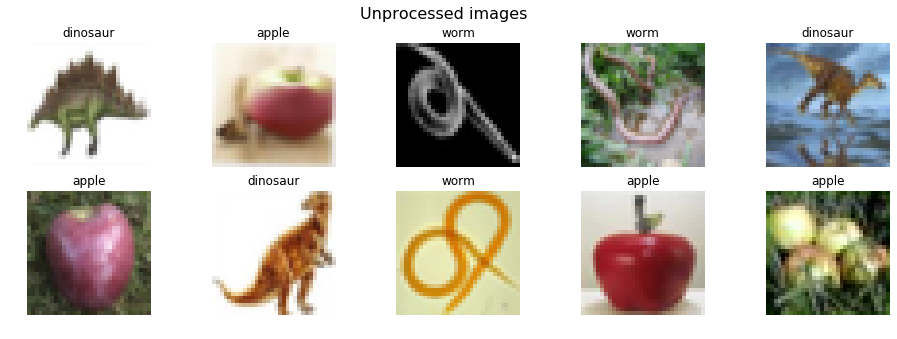

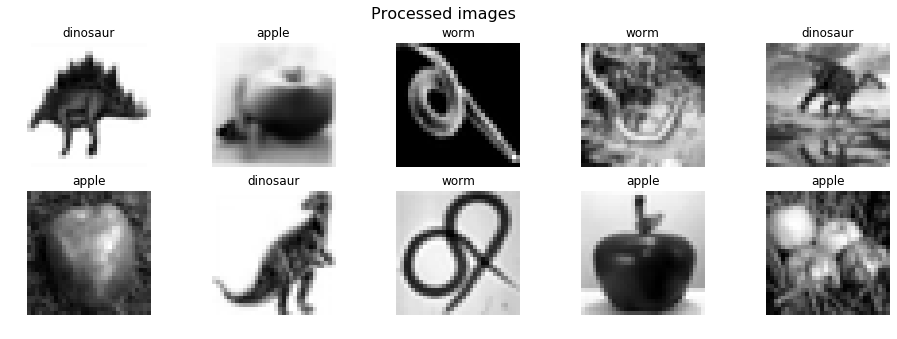

In [36]:
plt.figure(figsize=(16,5))
plt.suptitle("Unprocessed images", fontsize=16)
for n, elem in enumerate(train_dataset.take(10)):
    images, labels = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels == 1.)[0][0]]])
    plt.imshow(np.squeeze(images), cmap='gray')
    plt.axis('off')
    
plt.figure(figsize=(16,5))
plt.suptitle("Processed images", fontsize=16)
for n, elem in enumerate(train_dataset_bw.take(10)):
    images_bw, labels_bw = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels_bw == 1.)[0][0]]])
    plt.imshow(np.squeeze(images_bw), cmap='gray')
    plt.axis('off')

We will now batch and shuffle the Dataset objects.

In [37]:
train_dataset_bw = train_dataset_bw.batch(10)
train_dataset_bw = train_dataset_bw.shuffle(100)

test_dataset_bw = test_dataset_bw.batch(10)
test_dataset_bw = test_dataset_bw.shuffle(100)

#### Train a neural network model

Now we will train a model using the `Dataset` objects. We will use the model specification and function from the first part of this assignment, only modifying the size of the input images.

In [38]:
# Build and compile a new model with our original spec, using the new image size
    
cifar_model = get_model((32, 32, 1))

In [39]:
# Train the model for 15 epochs

history = cifar_model.fit(train_dataset_bw, validation_data=test_dataset_bw, epochs=15)

Epoch 1/15
150/150 [==============================] - 20s 135ms/step - loss: 1.0687 - accuracy: 0.4213 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
150/150 [==============================] - 18s 121ms/step - loss: 0.9249 - accuracy: 0.5687 - val_loss: 0.8072 - val_accuracy: 0.6267
Epoch 3/15
150/150 [==============================] - 19s 124ms/step - loss: 0.8094 - accuracy: 0.6367 - val_loss: 0.7758 - val_accuracy: 0.6333
Epoch 4/15
150/150 [==============================] - 18s 121ms/step - loss: 0.7592 - accuracy: 0.6527 - val_loss: 0.7530 - val_accuracy: 0.6300
Epoch 5/15
150/150 [==============================] - 18s 121ms/step - loss: 0.7156 - accuracy: 0.6900 - val_loss: 0.7599 - val_accuracy: 0.6300
Epoch 6/15
150/150 [==============================] - 18s 122ms/step - loss: 0.6917 - accuracy: 0.7000 - val_loss: 0.6572 - val_accuracy: 0.6800
Epoch 7/15
150/150 [==============================] - 18s 121ms/step - loss: 0.6490 - accuracy: 0.7313 - val_loss: 0.6452 

#### Plot the learning curves

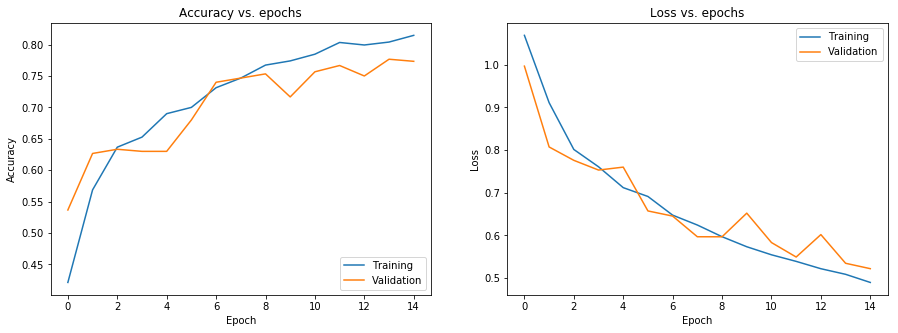

In [40]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    except KeyError:
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [41]:
# Create an iterable from the batched test dataset

test_dataset = test_dataset.batch(10)
iter_test_dataset = iter(test_dataset)

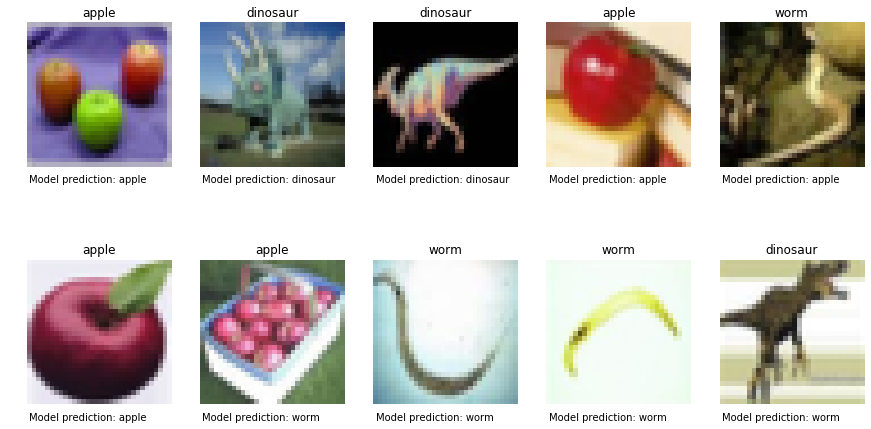

In [42]:
# Display model predictions for a sample of test images

plt.figure(figsize=(15,8))
inx = np.random.choice(test_data.shape[0], 18, replace=False)
images, labels = next(iter_test_dataset)
probs = cifar_model(tf.reduce_mean(tf.cast(images, tf.float32), axis=-1, keepdims=True) / 255.)
preds = np.argmax(probs, axis=1)
for n in range(10):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(images[n])
    plt.title(cifar_labels[cifar_classes[np.where(labels[n].numpy() == 1.0)[0][0]]])
    plt.text(0, 35, "Model prediction: {}".format(cifar_labels[cifar_classes[preds[n]]]))
    plt.axis('off')